<a href="https://colab.research.google.com/github/CarlosVaquero/BudgetBuddy/blob/main/tijl_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/CarlosVaquero/BudgetBuddy/

Cloning into 'BudgetBuddy'...
remote: Enumerating objects: 918, done.
remote: Counting objects: 100% (918/918), done.
remote: Compressing objects: 100% (852/852), done.
remote: Total 918 (delta 66), reused 914 (delta 64), pack-reused 0 (from 0)
Receiving objects: 100% (918/918), 504.58 KiB | 8.01 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [70]:
!pip install langchain_community
!pip install langchain-google-genai
!pip install langchain-chroma
!pip install faiss-cpu
!pip install -U langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 14.0 MB/s eta 0:00:00


In [75]:
import os
import getpass
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.vectorstores import FAISS
from langchain.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
import textwrap
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, trim_messages


In [30]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

## Create the vector store

### Add ing.nl data

In [33]:
# Specify the directory
directory = 'BudgetBuddy/data/ingnl'

# Create an empty list to store file paths
file_paths = []

# Walk through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        # Join the root directory with the file name to get the full path
        full_path = os.path.join(root, file)
        # Append the full path to the list
        file_paths.append(full_path)

In [38]:
# Load the document, split it into chunks, embed each chunk and load it into the vector store.
documents = []
for file_path in file_paths:
    documents.extend(TextLoader(file_path).load())
# text_splitter = CharacterTextSplitter(chunk_size=1000000, chunk_overlap=0)
# documents = text_splitter.split_documents(raw_documents)

In [55]:
#db_chroma = Chroma.from_documents(documents, GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"))
db_faiss = FAISS.from_documents(documents, GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"))

In [56]:
query = "Kan ik mijn creditcard transacties zien in Kijk Vooruit?"
docs = db_faiss.similarity_search(query)
for i, doc in enumerate(docs):
    print(f"\n\nDocument {i+1}:")
    print(doc.page_content)

Document 1:
# Creditcard rekeningoverzicht in Mijn ING en de Mobiel Bankieren App - ING

### Waarom zie ik niet dezelfde transacties als mijn partner?

Heb je een extra creditcard? Dan zie je altijd alleen de transacties die met die creditcard gedaan zijn. De transacties van je partner zie je niet terug in je rekeningoverzicht. Hierdoor kan het zijn dat het saldo niet lijkt te kloppen. Wat je ziet is het actuele beschikbare saldo voor beide creditcards. De hoofdkaarthouder ziet op zijn beurt wel alle transacties in het overzicht terug, ook die met de extra creditcard zijn gedaan. Met welke creditcard de transactie is gedaan zie je aan de laatste 4 cijfers die bij de transactie staan.
Houd er rekening mee dat je alleen het creditcard rekeningoverzicht ziet van de persoon die is ingelogd in de Mobiel Bankieren App of Mijn ING. Indien je een gezamenlijke rekening hebt, dan is de maandelijkse afschrijving inzichtelijk voor beide rekeninghouders.
Document 2:
# Creditcard rekeningoverzicht i

In [62]:
retriever = db_faiss.as_retriever(
    # search_type="mmr",
    search_kwargs={"k": 5},
)

In [63]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_ingnl_information",
    "Search and return information about (banking) products of ING, and features in the ING app that customers have available.",
)

tools = [retriever_tool]

In [66]:
# Create LLM model
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_retries=2
)

In [67]:
tools = [retriever_tool]
tools_names = {t.name: t for t in tools}
model = model.bind_tools(tools)

In [76]:
def wrap_text(text, width=100):
    text_split = text.split("\n")
    wrapped_text = textwrap.fill(text_split[0], width)
    if len(text_split) > 1:
        for line in text_split[1:]:
            wrapped_text += "\n" + textwrap.fill(line, width)
    return wrapped_text

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            print(wrap_text(message.pretty_repr()))

def ask(agent, question, config=None, verbose=False):
    messages = [HumanMessage(content=question)]
    if verbose:
        print_stream(agent.stream({"messages": messages}, config=config, stream_mode= "values"))
    else:
        result = agent.invoke({"messages": messages}, config=config)
        print(wrap_text(result['messages'][-1].content))

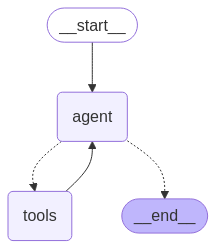

In [77]:
prompt = """
    You are a helpful assistant. Your goal is to find a satisfying answer to each
    question. If necessary, decompose the question into multiple tasks, and try
    to use the tools at your disposal to answer the subtasks before coming
    up with the final answer. Don't ask the user for confirmation. Just do stuff.
"""

agent = create_react_agent(model, tools, prompt=prompt)
display(Image(agent.get_graph().draw_mermaid_png()))

In [79]:
ask(agent, "Welke transacties zie ik allemaal in Kijk Vooruit?", verbose=True)

================================ Human Message =================================

Welke transacties zie ik allemaal in Kijk Vooruit?
================================== Ai Message ==================================
Tool Calls:
  retrieve_ingnl_information (889608ef-66fc-4e23-86bd-449647acc6e5)
 Call ID: 889608ef-66fc-4e23-86bd-449647acc6e5
  Args:
    query: Welke transacties zie ik allemaal in Kijk Vooruit?
================================= Tool Message =================================
Name: retrieve_ingnl_information

# Kijk Vooruit in de Mobiel Bankieren App - ING

## Wat zie je precies in Kijk Vooruit?

* Afschrijvingen die zeker gaan gebeuren
* Afschrijvingen die voorspeld worden op basis van eerdere afschrijvingen, zoals je energierekening
* Bijschrijvingen die voorspeld worden op basis van eerdere bijschrijvingen, zoals je salaris
* Spaaropdrachten die je hebt ingepland
* Het voorspelde saldo op basis van alle bedragen die van je rekening afgaan of erbij komen
Zo krijg je een be